# Wind sector management

In this example we switch off, derate or boost turbines according to wind conditions. Here are our imports: 

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV
import foxes.constants as FC

Our wind conditions come from the Bremen wind rose (part of `foxes`' static data):

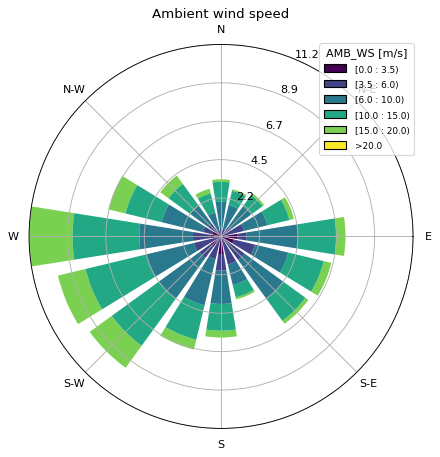

In [2]:
states = foxes.input.states.StatesTable(
    data_source="wind_rose_bremen.csv",
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS: "ws", FV.WD: "wd", FV.WEIGHT: "weight"},
    fixed_vars={FV.RHO: 1.225, FV.TI: 0.05},
)

o = foxes.output.StatesRosePlotOutput(states, point=[0., 0., 100.])
fig = o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()

The rules of wind sector management can either be given by a `pandas` readable file like `.csv`, or directly by a `pandas.DataFrame` object. Here we are persuing the latter option, for a wind farm that consists of two turbines, labelled `T0` and `T1`, where turbine `T1` is located east of turbine `T0`. This creates the table of rules:

In [3]:
rules = pd.DataFrame(columns=["tname", "WD_min", "WD_max", "WS_min", "WS_max", "MAXP"])
rules.index.name = "rule"
rules.loc[0] = ["T0", 170, 191, 3, 15, 500]
rules.loc[1] = ["T0", 250, 290, 9, 99, 0]
rules.loc[2] = ["T0", 340, 50, 0, 99, 0]
rules.loc[3] = ["T1", 70, 110, 3, 99, 0]
rules.loc[4] = ["T1", 250, 290, 9, 99, 6000]
rules

,tname,WD_min,WD_max,WS_min,WS_max,MAXP
rule,,,,,,
0,T0,170,191,3,15,500
1,T0,250,290,9,99,0
2,T0,340,50,0,99,0
3,T1,70,110,3,99,0
4,T1,250,290,9,99,6000


Note that we can add multiple rules per turbine. Additional conditions on ranges of other variables can be added in addition to `WD` and `WS` by simply adding the corresponsing columns with min and max data.

The final column `MAXP` defines the values of the state-turbine variable that should be set if the current wind conditions fulfill the formulated range conditions. It is possible to add more variables by adding the corresponding columns to the table.

Let's setup the model book, featuring the `SectorManagement` turbine model based on the above rules:

In [4]:
mbook = foxes.models.ModelBook()
ttype = foxes.models.turbine_types.PCtFile("NREL-5MW-D126-H90.csv")
mbook.turbine_types[ttype.name] = ttype

mbook.turbine_models["sector_rules"] = foxes.models.turbine_models.SectorManagement(
    data_source=rules,
    col_tnames="tname",
    range_vars=[FV.WD, FV.REWS],
    target_vars=[FV.MAX_P],
    colmap={"REWS_min": "WS_min", "REWS_max": "WS_max"},
)

Due to the stated ``range_vars` the model will look for columns `WD_min`, `WD_max`, `REWS_min`, `REWS_max`. The latter two have slightly different names in the DataFrame, hence the entries in the `colmap` dict. Notice that also target variable names could be mapped to other column names, if needed.

Now we create the wind farm with the two wind turbines in west-east orientation:

Turbine 0, T0: xy=(0.00, 0.00), NREL-5MW, sector_rules, PMask
Turbine 1, T1: xy=(600.00, 0.00), NREL-5MW, sector_rules, PMask


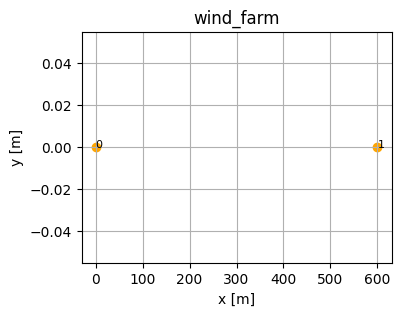

In [5]:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_row(
    farm=farm,
    xy_base=[0.0, 0.0],
    xy_step=[600.0, 0.0],
    n_turbines=2,
    turbine_models=[ttype.name, "sector_rules", "PMask"],
)

ax = foxes.output.FarmLayoutOutput(farm).get_figure(figsize=(4, 3))
plt.show(ax.get_figure())

The turbine model `PMask` was added in order to evaluate the variable `MAXP` that was set by the `sector_rules` model. It is responsible for switching off, derating or boosting turbines, cf. example `Power mask`.

Now let's create an algorithm object and run the case:

In [6]:
algo = foxes.algorithms.Downwind(
    farm,
    states=states,
    rotor_model="centre",
    wake_models=["Bastankhah2014_linear_k002"],
    mbook=mbook,
    chunks={FC.STATE: 500},
    verbosity=0,
)

In [7]:
farm_results = algo.calc_farm()

The effect of the rules is best visualized in rose plots for the two turbines:

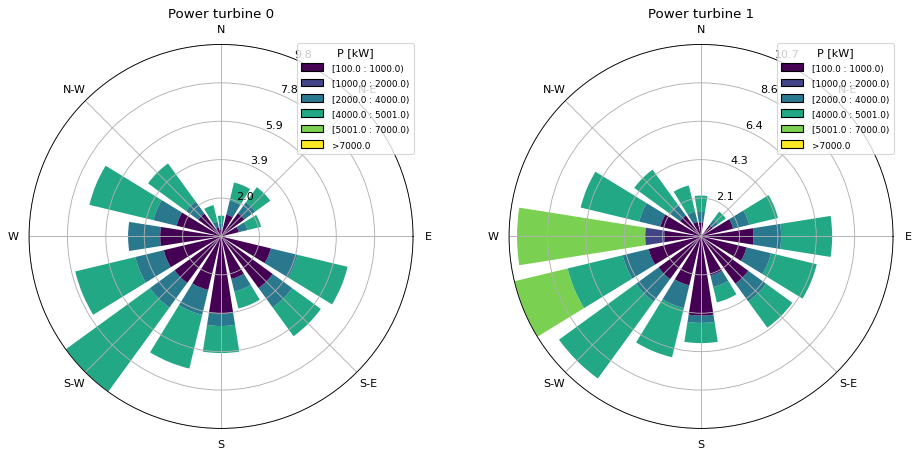

In [8]:
o = foxes.output.RosePlotOutput(farm_results)
fig = o.get_figure(
    16,
    FV.P,
    [100, 1000, 2000, 4000, 5001, 7000],
    turbine=0,
    title="Power turbine 0",
    figsize=(12, 6),
    rect=[0.05, 0.1, 0.4, 0.8],
)

o = foxes.output.RosePlotOutput(farm_results)
fig = o.get_figure(
    16,
    FV.P,
    [100, 1000, 2000, 4000, 5001, 7000],
    turbine=1,
    title="Power turbine 1",
    fig=fig,
    rect=[0.35, 0.1, 0.8, 0.8],
)
plt.show()

The wind sector management has the following effects (compare to the `rules` table above):

- Turbine 0 switches off at high wind speeds for westerly wind directions
- Turbine 1 is boosted for such winds
- Turbine 1 switches off completely for wind from east
- Turbine 0 is derated for wind from south
- Turbine 0 switches off for wind from north